### Modelling

Target variable -  categorical 

models - Logistic regression , tree-based models 

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.linear_model import LogisticRegression

In [14]:
df = pd.read_csv('waze_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


> there are 700 missing values in the target variable

In [15]:
# drop ID column
df.drop(['ID'],axis=1,inplace=True)

In [5]:
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

In [6]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


> The class is not highly imbalanced.

> The following columns seem to have outliers 'sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives' as all of these columns have max values that are multiple standard deviations above the 75th percentile.

#### Feature Engineering

In EDA we have seen that km_per_driving_day , drives_per_driving_day are correlated with the churn rate. If we include both features there will be high multicolinearity so lets include only one.

In [16]:
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Note that some values are infinite. This is the result of there being values of zero in the driving_days column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

>Convert these values from infinity to zero. You can use np.inf to refer to a value of infinity.

In [17]:
df.loc[df['km_per_driving_day']==np.inf,'km_per_driving_day']=0
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

Create a new, binary feature called professional_driver that is a 1 for users who had 60 or more drives and drove on 15+ days in the last month.

>Note: The objective is to create a new feature that separates professional drivers from other drivers

In [18]:
df['professional_driver']=np.where((df['drives']>=60)&(df['driving_days']>=15),1,0)
df['professional_driver'].value_counts(normalize=True)

professional_driver
0    0.827055
1    0.172945
Name: proportion, dtype: float64

In [10]:
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

> The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

### Preparing data for modeling

In [11]:
# 1. drop missing values
df.dropna(subset=['label'],inplace=True)

In [21]:
df.shape

(14999, 14)

In [23]:
cols = ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']
for col in cols:
    threshold = df[col].quantile(0.75)
    n= df[df[col]>threshold].shape[0]
    print(f'no.of outliers in {col} = {n}')

no.of outliers in sessions = 3705
no.of outliers in drives = 3723
no.of outliers in total_sessions = 3750
no.of outliers in total_navigations_fav1 = 3737
no.of outliers in total_navigations_fav2 = 3715
no.of outliers in driven_km_drives = 3750
no.of outliers in duration_minutes_drives = 3750


In [22]:
cols = ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']
for col in cols:
    threshold = df[col].quantile(0.95)
    n= df[df[col]>threshold].shape[0]
    print(f'no.of outliers in {col} = {n}')

no.of outliers in sessions = 747
no.of outliers in drives = 741
no.of outliers in total_sessions = 750
no.of outliers in total_navigations_fav1 = 747
no.of outliers in total_navigations_fav2 = 733
no.of outliers in driven_km_drives = 750
no.of outliers in duration_minutes_drives = 750


In [25]:
# 2. Imputing Outliers 
# impute outliers with 95th percentile values
cols = ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']
for col in cols:
    threshold = df[col].quantile(0.95)
    df.loc[df[col]>threshold,col]=threshold
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,76.568705,64.058204,184.031320,1749.837789,114.415228,27.214281,3939.632764,1789.647426,15.537102,12.179879,578.963113,0.172945
std,67.297958,55.306924,118.600463,1008.513876,124.686795,36.735583,2216.041510,1222.705167,9.004655,7.824036,1030.094384,0.378212
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,136.238895,0.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,272.889272,0.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,558.686918,0.000000
max,243.000000,201.000000,454.363204,3500.000000,424.000000,124.000000,8889.794236,4668.899349,31.000000,30.000000,15420.234110,1.000000


In [26]:
# 3. encoding categorical variables label , device
df['label2']=np.where(df['label']=='churned',1,0)
df['device2']=np.where(df['device']=='Android',0,1)

#### checking model assumptions

The following are the assumptions for logistic regression:

>Independent observations (This refers to how the data was collected.)

>No extreme outliers

>Little to no multicollinearity among X predictors

>Linear relationship between X and the logit of y

For the first assumption, you can assume that observations are independent for this project.
The second assumption has already been addressed.
The last assumption will be verified after modeling.

In [27]:
corr= df[df.describe().columns].corr(method='pearson')
corr

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2,device2
sessions,1.000000,0.996907,0.595796,0.006480,0.003123,0.009746,0.001425,-0.005364,0.024374,0.018518,-0.011099,0.443151,0.033695,0.010453
drives,0.996907,1.000000,0.593945,0.006198,0.002307,0.010365,0.001789,-0.004763,0.023821,0.018036,-0.010609,0.443705,0.034528,0.009457
total_sessions,0.595796,0.593945,1.000000,0.005328,0.002377,0.008061,-0.000835,-0.001456,0.015932,0.012568,-0.014563,0.254599,0.022467,0.010012
n_days_after_onboarding,0.006480,0.006198,0.005328,1.000000,0.001232,-0.007468,-0.002852,-0.009140,-0.009725,-0.008563,0.011631,0.001364,-0.124711,-0.012044
total_navigations_fav1,0.003123,0.002307,0.002377,0.001232,1.000000,0.002467,-0.007898,0.002722,0.012176,0.011339,-0.002056,0.001135,0.051766,0.002030
total_navigations_fav2,0.009746,0.010365,0.008061,-0.007468,0.002467,1.000000,0.003831,-0.000951,-0.003489,0.003197,0.004308,0.006892,0.014263,-0.002156
driven_km_drives,0.001425,0.001789,-0.000835,-0.002852,-0.007898,0.003831,1.000000,0.690996,-0.005620,-0.007816,0.343509,0.000219,0.020131,-0.000526
duration_minutes_drives,-0.005364,-0.004763,-0.001456,-0.009140,0.002722,-0.000951,0.690996,1.000000,-0.005852,-0.007585,0.238133,-0.010022,0.040527,-0.007708
activity_days,0.024374,0.023821,0.015932,-0.009725,0.012176,-0.003489,-0.005620,-0.005852,1.000000,0.947706,-0.397062,0.452947,-0.295190,-0.009296
driving_days,0.018518,0.018036,0.012568,-0.008563,0.011339,0.003197,-0.007816,-0.007585,0.947706,1.000000,-0.407633,0.468653,-0.286080,-0.003558


<Axes: >

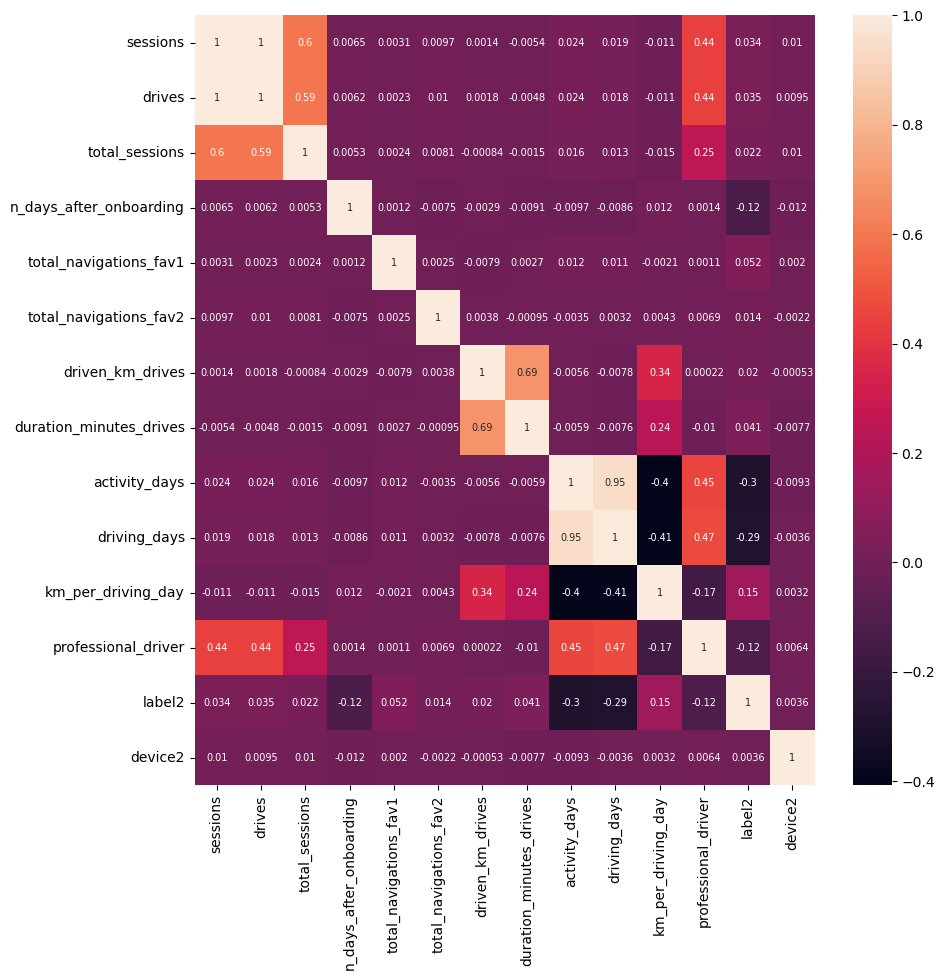

In [28]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,annot_kws={'size':7})

In [29]:
corr_pairs = corr.unstack()
sorted_corr_pairs = corr_pairs[(corr_pairs!=1.0)].abs().sort_values(ascending=False)
filtered_corr_pairs = sorted_corr_pairs.reset_index().drop_duplicates(subset=[0],keep='first')
filtered_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
a = filtered_corr_pairs[filtered_corr_pairs['Correlation']>0.1]

In [30]:
a

,Variable 1,Variable 2,Correlation
0,sessions,drives,0.996907
2,driving_days,activity_days,0.947706
4,driven_km_drives,duration_minutes_drives,0.690996
6,total_sessions,sessions,0.595796
8,total_sessions,drives,0.593945
10,driving_days,professional_driver,0.468653
12,professional_driver,activity_days,0.452947
14,drives,professional_driver,0.443705
16,sessions,professional_driver,0.443151
18,driving_days,km_per_driving_day,0.407633


In [42]:
corr_cols = list(set(np.append(a['Variable 1'].values, a['Variable 2'].values)))
corr_cols 

['duration_minutes_drives',
 'n_days_after_onboarding',
 'km_per_driving_day',
 'driving_days',
 'total_sessions',
 'activity_days',
 'driven_km_drives',
 'sessions',
 'drives',
 'label2',
 'professional_driver']

In [133]:
num_cols = ['duration_minutes_drives',
 'n_days_after_onboarding',
 'km_per_driving_day',
 'driving_days',
 'total_sessions',
 'activity_days',
 'driven_km_drives',
 'sessions',
 'drives',
 'professional_driver',
 'total_navigations_fav1',
 'total_navigations_fav2'
 ]

In [142]:
## VIF values
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[corr_cols]
X=df[num_cols]

X = sm.add_constant(X)


In [143]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data['Feature'] != 'const']
vif_data

,Feature,VIF
1,duration_minutes_drives,1.914802
2,n_days_after_onboarding,1.000448
3,km_per_driving_day,1.397953
4,driving_days,10.245808
5,total_sessions,1.550942
6,activity_days,9.851270
7,driven_km_drives,2.076417
8,sessions,162.510304
9,drives,162.133998
10,professional_driver,1.697231


In [141]:
# Remove sessions feature as it has the highest vif
l = ['duration_minutes_drives','n_days_after_onboarding', 'km_per_driving_day', 'driving_days', 'total_sessions', 'activity_days', 'driven_km_drives', 'drives', 'label2', 'professional_driver']
X = df[l]

X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data['Feature'] != 'const']
vif_data

,Feature,VIF
1,duration_minutes_drives,1.917061
2,n_days_after_onboarding,1.018658
3,km_per_driving_day,1.398982
4,driving_days,10.244108
5,total_sessions,1.545648
6,activity_days,9.910190
7,driven_km_drives,2.076688
8,drives,1.881871
9,label2,1.120891
10,professional_driver,1.696965


In [139]:
# remove driving days as it has the highest vif > 10
l = ['duration_minutes_drives','n_days_after_onboarding', 'km_per_driving_day', 'total_sessions', 'activity_days', 'driven_km_drives', 'drives', 'label2', 'professional_driver']
X = df[l]

X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data['Feature'] != 'const']
vif_data

# no need to further remove the features as all have vif LESS THAN 5

,Feature,VIF
1,duration_minutes_drives,1.917058
2,n_days_after_onboarding,1.018657
3,km_per_driving_day,1.379869
4,total_sessions,1.545641
5,activity_days,1.639449
6,driven_km_drives,2.075241
7,drives,1.869442
8,label2,1.120591
9,professional_driver,1.648014


#### train_test_split

In [52]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2,device2
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,76.568705,64.058204,184.031320,1749.837789,114.415228,27.214281,3939.632764,1789.647426,15.537102,12.179879,578.963113,0.172945,0.169078,0.644843
std,67.297958,55.306924,118.600463,1008.513876,124.686795,36.735583,2216.041510,1222.705167,9.004655,7.824036,1030.094384,0.378212,0.374833,0.478577
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,136.238895,0.000000,0.000000,0.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,272.889272,0.000000,0.000000,1.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,558.686918,0.000000,0.000000,1.000000
max,243.000000,201.000000,454.363204,3500.000000,424.000000,124.000000,8889.794236,4668.899349,31.000000,30.000000,15420.234110,1.000000,1.000000,1.000000


In [83]:
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])
y = df['label2']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler  = StandardScaler()
x_train = scaler.fit_transform(X_train) # scaled x_train 
x_test = scaler.transform(X_test) # scaled x_test

In [84]:
model1 = LogisticRegression(penalty='none', max_iter=400)

model1.fit(x_train, y_train)

/Users/amruthakaruturi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(max_iter=400, penalty='none')

In [85]:
pd.Series(model1.coef_[0], index=X.columns), model1.intercept_

(drives                     0.129676
 total_sessions            -0.000512
 n_days_after_onboarding   -0.380860
 total_navigations_fav1     0.148956
 total_navigations_fav2     0.043404
 driven_km_drives          -0.064688
 duration_minutes_drives    0.158778
 activity_days             -0.907473
 km_per_driving_day         0.010242
 professional_driver        0.013361
 device2                   -0.014255
 dtype: float64,
 array([-1.90042691]))

**Check final assumption**

Verify the linear relationship between X and the estimated log odds (known as logits) by making a regplot.

In [146]:
training_probabilities = model1.predict_proba(pd.DataFrame(x_train))
training_probabilities

array([[0.63531718, 0.36468282],
       [0.79880266, 0.20119734],
       [0.79182874, 0.20817126],
       ...,
       [0.82805028, 0.17194972],
       [0.95610859, 0.04389141],
       [0.85065127, 0.14934873]])

In [147]:
logit_data = pd.DataFrame(x_train)
logit_data.columns = X_train.columns
logit_data['logit'] =  [np.log(prob[1] / prob[0]) for prob in training_probabilities]

In [110]:
logit_data

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2,logit
0,-0.255649,-0.787341,-0.701668,-0.913655,-0.333323,1.187832,-0.230527,-1.507035,-0.572694,-0.455371,-1.346982,-0.555096
1,-0.346007,0.506396,-0.264273,-0.913655,0.211765,0.780551,2.364651,-0.281989,-0.097295,-0.455371,-1.346982,-1.378828
2,-0.291792,-1.031797,-1.001199,1.986583,-0.660376,-0.613359,-0.307771,0.052115,-0.336640,-0.455371,-1.346982,-1.335984
3,-0.924303,0.027394,1.546800,0.560499,0.130002,-1.368302,-1.218597,-0.616092,-0.481375,-0.455371,-1.346982,-2.057981
4,-1.123092,-0.501696,-0.936730,-0.913655,-0.742140,-0.505642,0.196485,-1.729771,-0.572694,-0.455371,0.742400,-0.246259
...,...,...,...,...,...,...,...,...,...,...,...,...
11244,1.226234,0.787916,-0.164098,-0.857573,-0.742140,0.641195,1.816504,-0.504724,0.197884,-0.455371,-1.346982,-1.119161
11245,-0.797801,-1.323942,-1.018060,2.483308,-0.742140,0.819390,0.064711,-1.729771,-0.572694,-0.455371,0.742400,0.226681
11246,1.226234,0.400267,0.670026,-0.601198,-0.742140,-0.744029,-0.254117,-0.616092,-0.342172,-0.455371,0.742400,-1.571872
11247,0.123858,-0.434185,-0.480491,-0.585175,-0.060779,-1.032594,-0.696668,1.388529,-0.497159,2.196011,0.742400,-3.081153


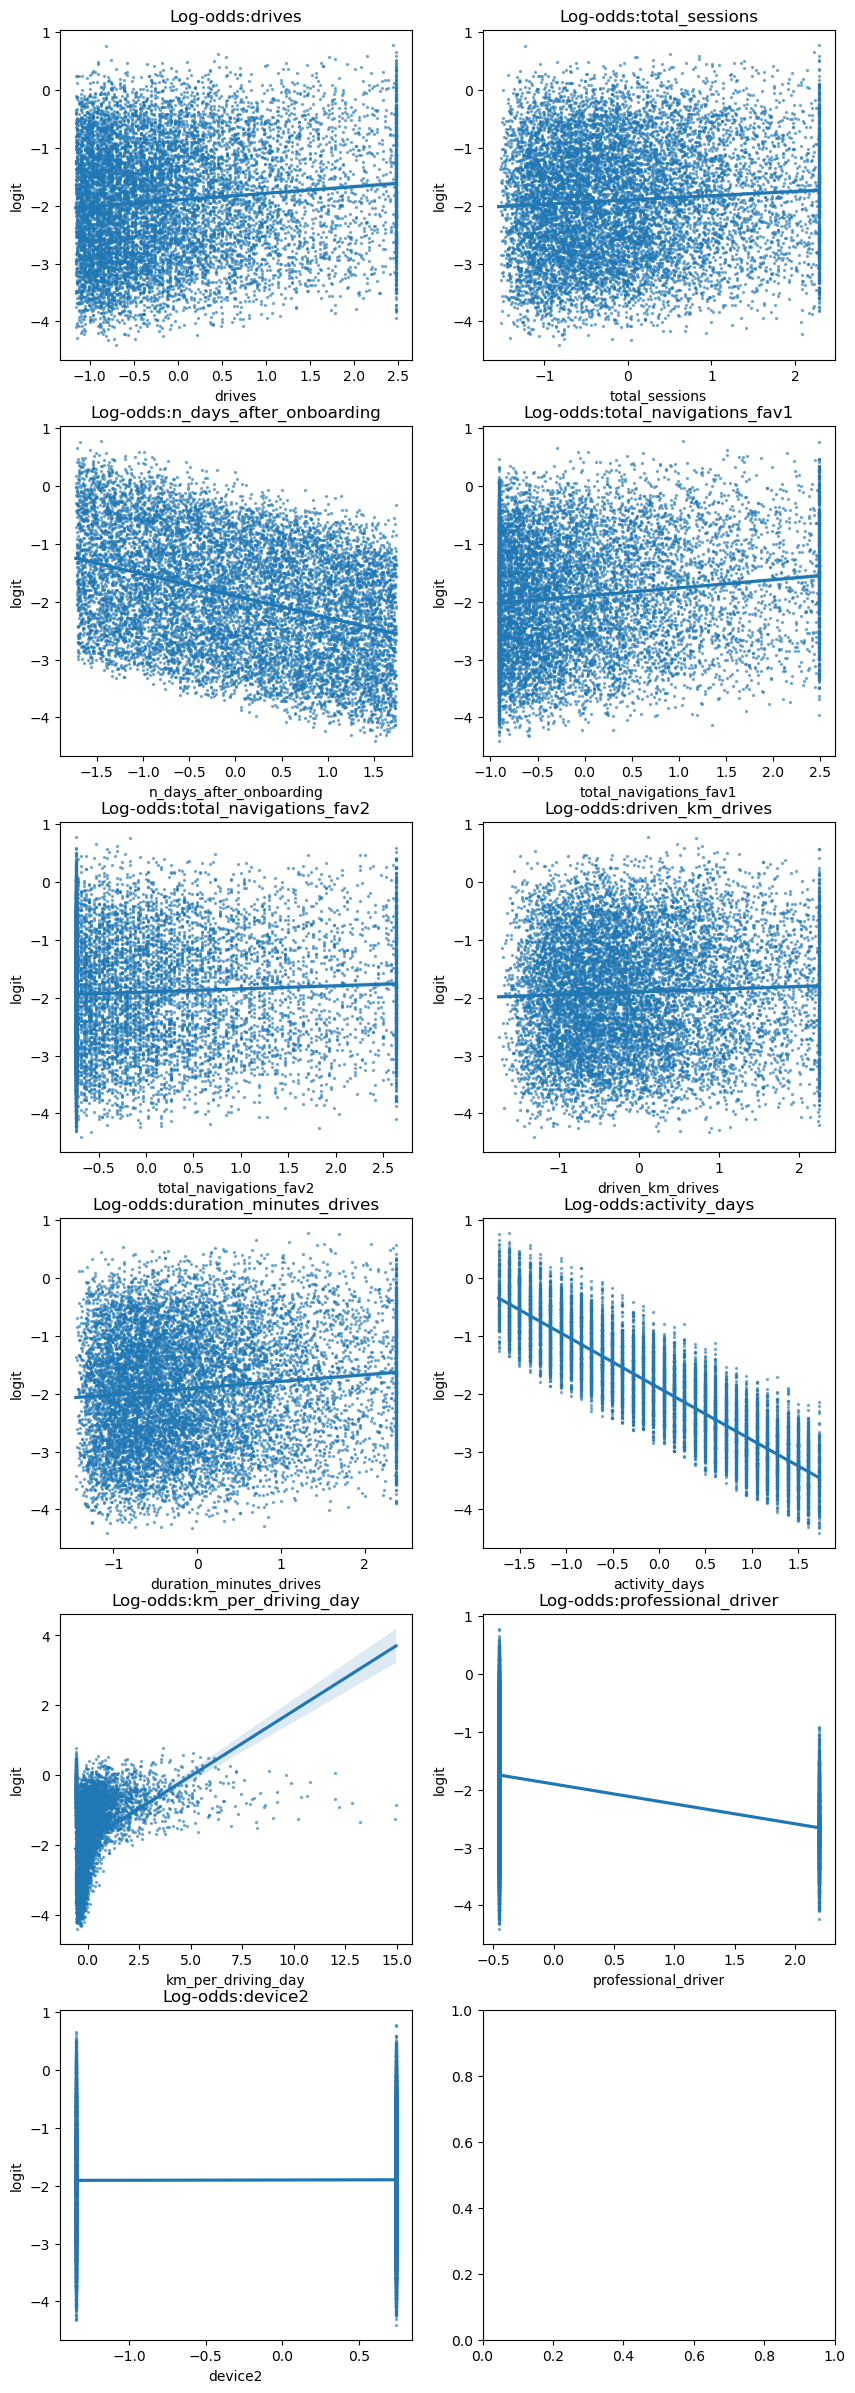

In [149]:
cols= logit_data.columns[:-1]
cols

fig,ax =plt.subplots(nrows=6,ncols=2,figsize=(10,30))
i=0
for col in cols:
    sns.regplot(x=col,y='logit',data=logit_data,scatter_kws={'s': 2, 'alpha': 0.5},ax=ax[i//2][i%2])
    ax[i//2][i%2].set_title(f'Log-odds:{col}')
    i=i+1

#### Evaluation on test data

In [150]:
y_preds = model1.predict(pd.DataFrame(x_test))
model1.score(pd.DataFrame(x_test), y_test) # returns accuracy_score

0.8306666666666667

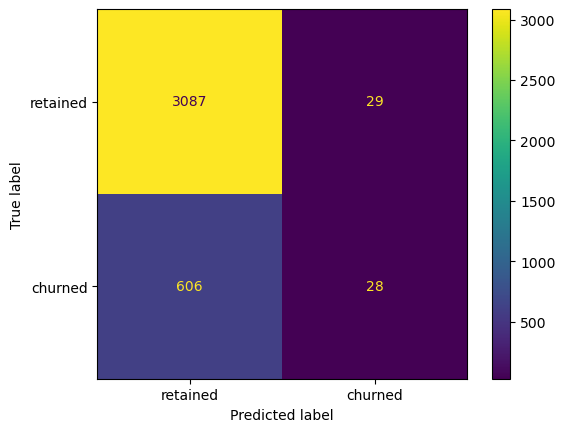

In [151]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

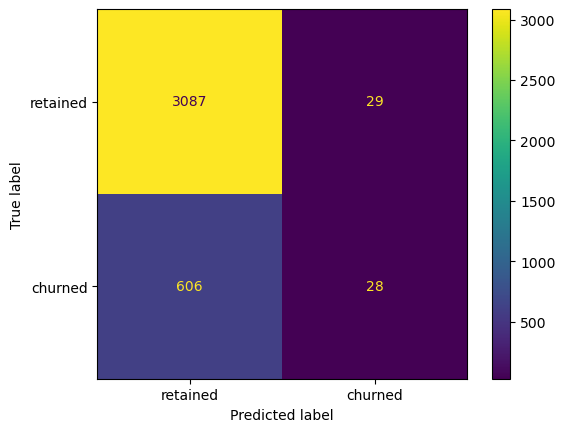

In [112]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [152]:
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.84      0.99      0.91      3116
     churned       0.49      0.04      0.08       634

    accuracy                           0.83      3750
   macro avg       0.66      0.52      0.49      3750
weighted avg       0.78      0.83      0.77      3750



The model has mediocre precision and very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

In [153]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

NameError: name 'model' is not defined

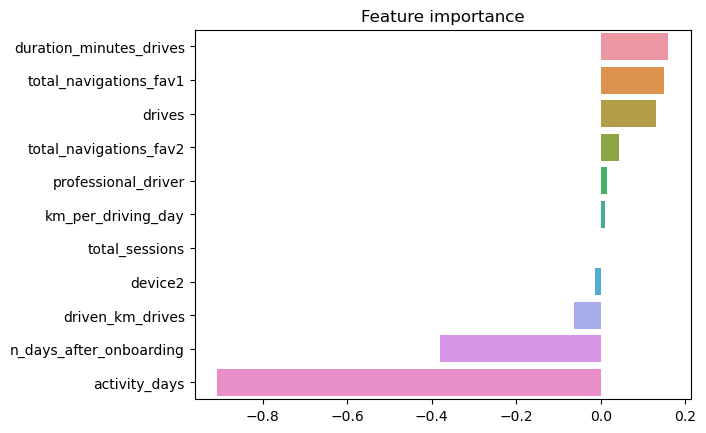

In [154]:
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

In [155]:
num_cols = ['drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'km_per_driving_day',
       'professional_driver', 'device2']
df.groupby(['label'])[num_cols].median()


,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
label,,,,,,,,,,,
churned,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,407.597934,0.0,1.0
retained,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,256.056187,0.0,1.0


In [159]:
df

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver,label2,device2
0,retained,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1,0,0
1,retained,133,107,326.896596,1225,19,64,8889.794236,3160.472914,13,11,iPhone,1246.901868,0,0,1
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0,0,1
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,retained,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,iPhone,170.029229,0,0,1
14995,retained,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,Android,203.128760,0,0,0
14996,retained,243,201,422.017241,1873,17,0,3097.825028,1031.278706,18,17,iPhone,182.225002,1,0,1
14997,churned,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,iPhone,675.293092,0,1,1


In [160]:
df.groupby(['device'])['label'].value_counts(normalize=True)

device   label   
Android  retained    0.824399
         churned     0.175601
iPhone   retained    0.821680
         churned     0.178320
Name: proportion, dtype: float64

In [162]:
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

Professional drivers have less churn rate compared to non_professional_drivers. negative correlation with target.??